### Cena 4
- Simulação com a mini câmara com material 1 cm sendo um fluido equivalente.




### Importando bibliotecas


In [1]:
# Importando bibliotecas

import femder as fd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
from femder.FEM_3D import  p2SPL

Default Plotly renderer: jupyterlab


### Importando resultados experimentais
- velocidade de volume
- coef. absorção ISO 354
- sinal medido nos receptores
- respostas impulsivas

In [2]:
import scipy.io as sio

q = sio.loadmat(r'G:\\Meu Drive\\TCC\\Simulacao_computacional\\Qi.mat')
# sorted(q.keys())
q = q['Qi']

as_medido = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\com_material\\espessura_menor\\a_s.mat')
# sorted(as_medido.keys())

R_comMat = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\com_material\\espessura_menor\\pts_freq.mat')
# sorted(R_semMat.keys())

RI_comMat = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\com_material\\espessura_menor\\RIs.mat')



### Importar geometria, inicializando as classes dos dados de entrada da simulação

In [3]:
# Importar geometria, inicializando as classes dos dados de entrada da simulação

path_to_geo = "G:\Meu Drive\TCC\Simulacao_computacional\codes\geo\material_menosEspesso\menosEspesso_comvol.geo"

AP = fd.AirProperties(c0 = 343)
fmax = 2000 #2300
fmin = 150
AC = fd.AlgControls(AP,fmin,fmax,0.5)
S = fd.Source("spherical")
S.coord = np.array([[1.222,0.15,0.2]])
S.q = np.array(q)
#S.q = np.array([0.001])
R = fd.Receiver()
#R.coord = np.array([[0.33,0.23,0.21],[0.38,0.93,0.21],[0.92,0.95,0.21]]) 
R.coord = np.array([[1.057,0.695,0.282],[0.425,0.925,0.235],
                    [0.409,0.406,0.235],[0.336,0.677,0.282],
                    [0.685,0.965,0.235],[0.661,0.30,0.235]])
 

In [4]:
# Boundary Conditions
BC = fd.BC(AC,AP) #[2,3,4,5,6,7]
BC.delany(1,RF=12100, model='miki');
BC.normalized_admittance([3,4,5,7,8,9,10,11,12,13,14,15],0.004)
#BC.delany(6,RF=12100, d=0.025, model='miki')

### Verificação da equivalência entre os alphas (in x recuperado)

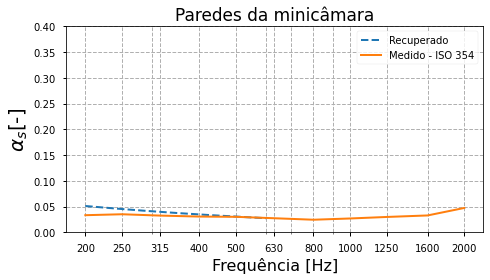

In [44]:
# Verificação da equivalência entre os coefs 
## () analisar recuperando com alphas em bando de terç de oitava
## () calcular erro entre os coefs

plt.figure(figsize=(7,4))
plt.semilogx(AC.freq, sup.statistical_alpha,label='Recuperado', linestyle='--', linewidth=2)
plt.semilogx(as_medido['f'][:11], as_medido['a_s'][:11], linestyle='-', label = 'Medido - ISO 354',linewidth=2)
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.title('Paredes da minicâmara', fontsize=17)
plt.xlabel('Frequência [Hz]', fontsize=16)
plt.ylabel(r'$\alpha_{s}$[-]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
plt.tight_layout()
plt.ylim((0,0.4))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
plt.show()

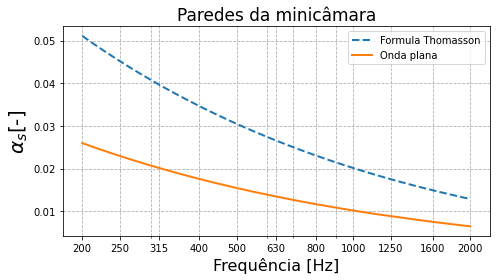

In [28]:
# Coeficiente de reflexão e absorção formula incidencia normal
z_ar = AP.c0*AP.rho0
Zs = sup_surface_impedance/z_ar
Reflexao = (Zs - 1) / (Zs + 1)
Absorcao = 1 - (np.abs(Reflexao) ** 2)  # 1 - |R|²
plt.figure(figsize=(7,4))
plt.semilogx(AC.freq, sup.statistical_alpha,label='Formula Thomasson', linestyle='--', linewidth=2)
plt.semilogx(AC.freq, Absorcao, linestyle='-', label = 'Incidência normal',linewidth=2)
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.title('Paredes da minicâmara', fontsize=17)
plt.xlabel('Frequência [Hz]', fontsize=16)
plt.ylabel(r'$\alpha_{s}$[-]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
plt.tight_layout()
# plt.ylim((0,0.2))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
plt.show()

### Geração da malha, inicializando a classe FEM3D com os dados de entrada e o plote da geomeria com a malha 2D


In [5]:
grid = fd.GridImport3D(AP,path_to_geo,S,R,fmax = fmax,num_freq=6,scale=1000,order=1,load_method='meshio')
obj = fd.FEM3D(grid,S,R,AP,AC,BC)
obj.plot_problem(renderer='browser',saveFig=False,camera_angles=['diagonal_front'],extension='png')

### Cálculo das pressões com o método de elementos finitos

In [25]:
obj.compute() # debug e comparar vel const e dpendente freqa
obj.evaluate(R,True)

FEM | Assembling surface matrix: 100%|█████████████████████████| 13/13 [00:00<00:00, 71.19it/s]
100%|██████████| 325397/325397 [00:39<00:00, 8308.29it/s]


In [15]:
# Salva var
with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara_comMat\\espessura2_5cm\\fluido_eq\obj_Minicamara4_150_2000_0_5.pkl", "wb") as arquivo:
    pickle.dump(obj.pR, arquivo)


### Plote dos NPS resultantes em cada receptor

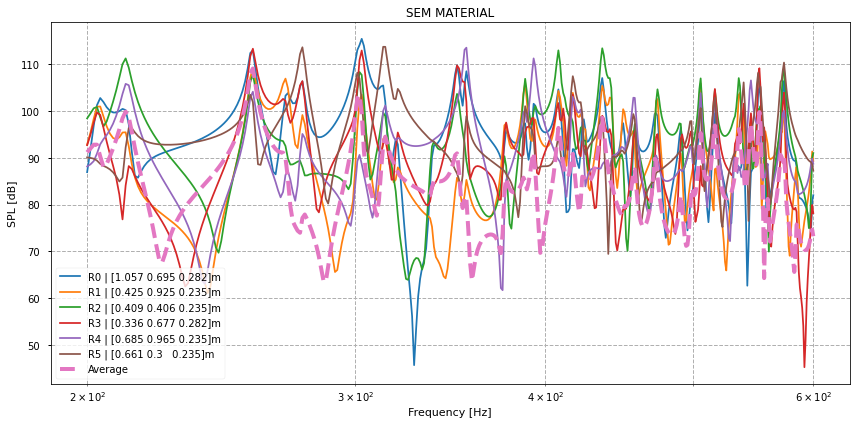

In [31]:

plt.style.use('seaborn-notebook')
plt.figure(figsize=(12,6))

if len(obj.R.coord)==1:
  plt.semilogx(obj.freq, p2SPL(obj.pR), linestyle='-', label=f'R | {obj.R.coord[0]}m')
else:
  for i in range(len(obj.R.coord)):
      plt.semilogx(obj.freq, p2SPL(obj.pR[:,i]), linestyle='-', label=f'R{i} | {obj.R.coord[i,:]}m')

if len(obj.R.coord) > 1:
  pR_med = np.mean(obj.pR,axis=1)
  plt.semilogx(obj.freq, p2SPL(pR_med), linestyle='--', label='Average', linewidth=4)
plt.title('SEM MATERIAL')
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL [dB]')
#plt.ylim(40,160)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([100,125,160,200,250,315,400,500,630,1000,1250],[100,125,160,200,250,315,400,500,630,1000,1250]);
#plt.ylim(40,160)
plt.tight_layout()
plt.show()

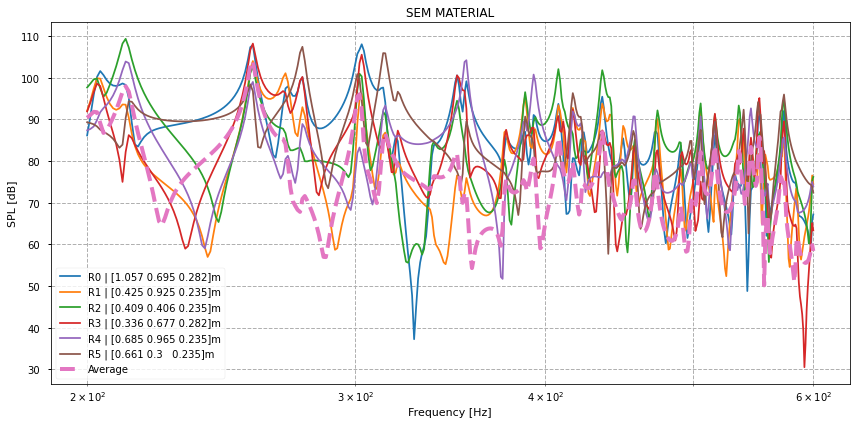

In [25]:
# Plote dos NPS resultantes em cada receptor
plt.style.use('seaborn-notebook')
plt.figure(figsize=(12,6))

if len(obj.R.coord)==1:
  plt.semilogx(obj.freq, p2SPL(obj.pR), linestyle='-', label=f'R | {obj.R.coord[0]}m')
else:
  for i in range(len(obj.R.coord)):
      plt.semilogx(obj.freq, p2SPL(obj.pR[:,i]), linestyle='-', label=f'R{i} | {obj.R.coord[i,:]}m')

if len(obj.R.coord) > 1:
  pR_med = np.mean(obj.pR,axis=1)
  plt.semilogx(obj.freq, p2SPL(pR_med), linestyle='--', label='Average', linewidth=4)
plt.title('SEM MATERIAL')
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL [dB]')
#plt.ylim(40,160)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([100,125,160,200,250,315,400,500,630,1000,1250],[100,125,160,200,250,315,400,500,630,1000,1250]);
#plt.ylim(40,160)
plt.tight_layout()
plt.show()

### Comparação NPS dos pontos medido e simulado

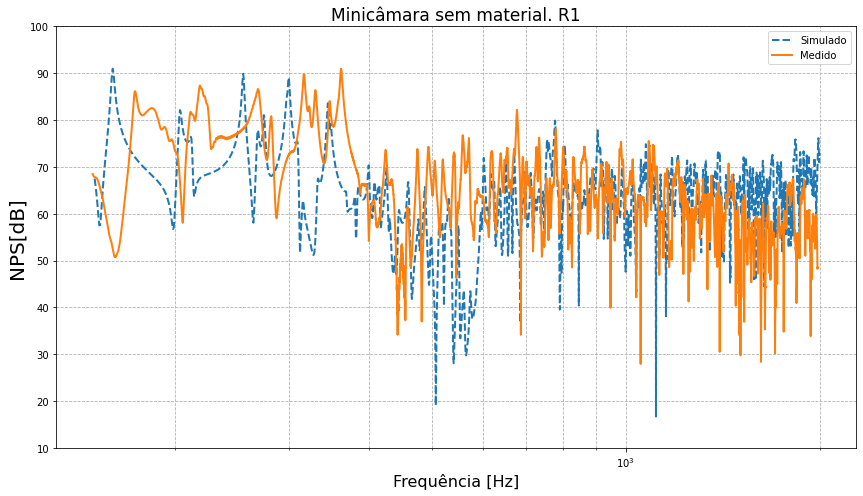

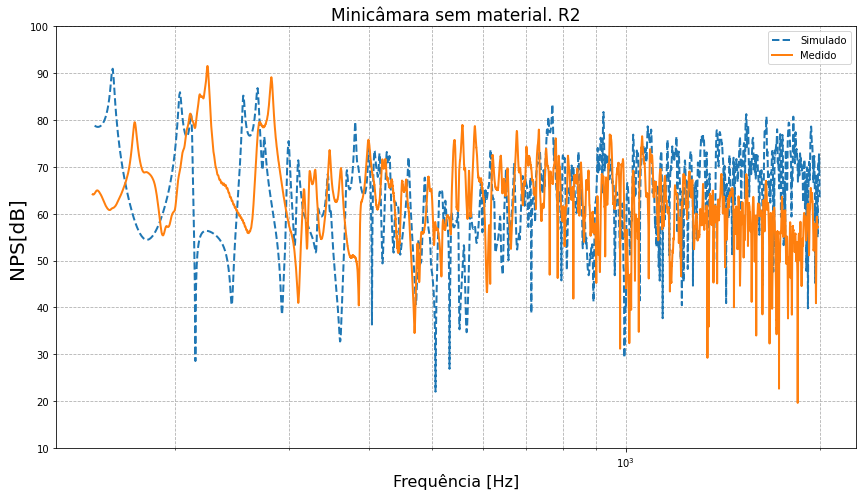

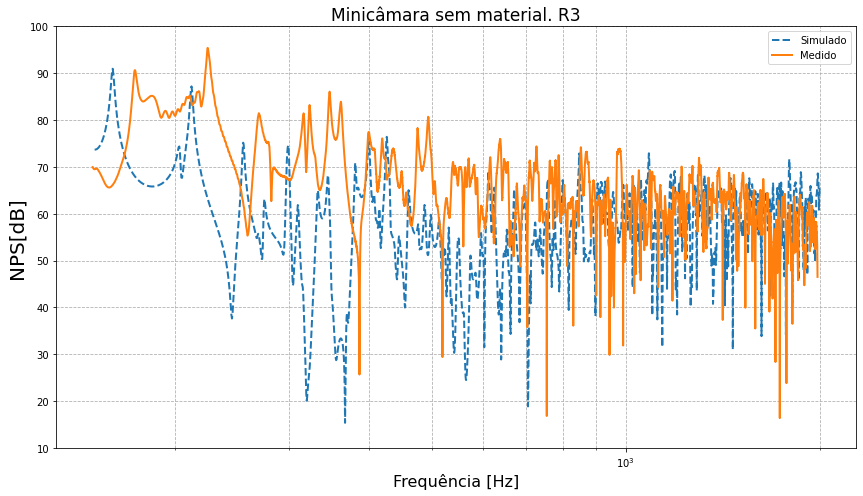

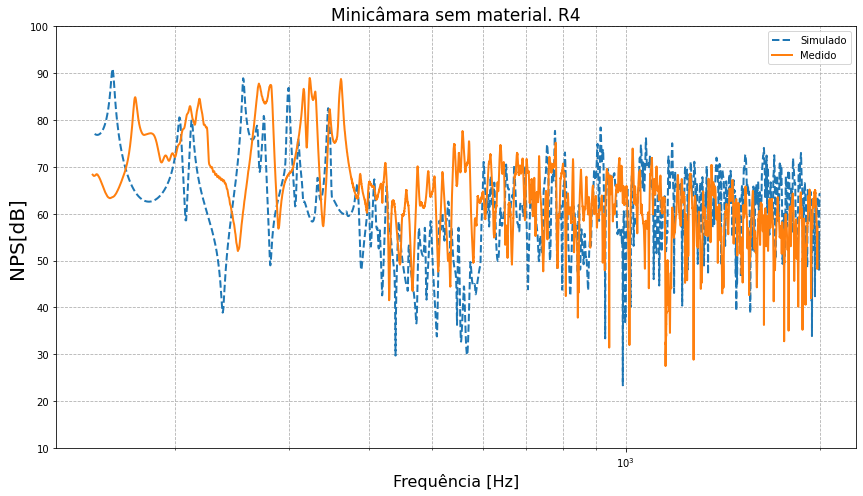

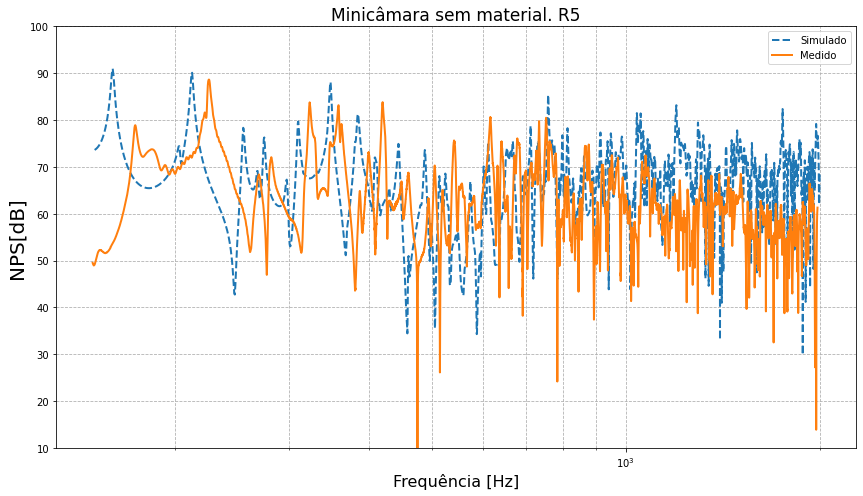

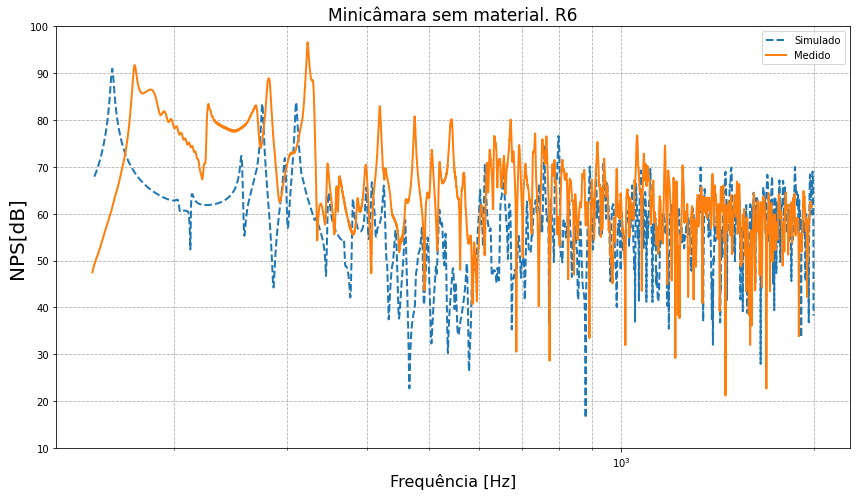

In [17]:
#Comparação NPS dos pontos medido e simulado  
# Q - Dependente da freq

for n in range(0,6):
    plt.figure(figsize=(12,7))
    plt.semilogx(AC.freq, p2SPL(obj.pR[:,n]/max(abs(obj.pR[:,n]))),label='Simulado', linestyle='--', linewidth=2)
    plt.semilogx(R_semMat['freqVector'][1981:26401,0], p2SPL(R_semMat['pts_freq'][1981:26401,n]/max(abs(R_semMat['pts_freq'][2641:7921,0]))), linestyle='-', label = 'Medido',linewidth=2)
    plt.grid(linestyle = '--', which='both')
    plt.legend(loc='best')
    plt.title(f'Minicâmara sem material. R{n+1}', fontsize=17)
    plt.xlabel('Frequência [Hz]', fontsize=16)
    plt.ylabel(r'NPS[dB]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
    plt.tight_layout()
    plt.ylim((10,100))
# plt.ylim((0,0.2))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
    plt.show()  

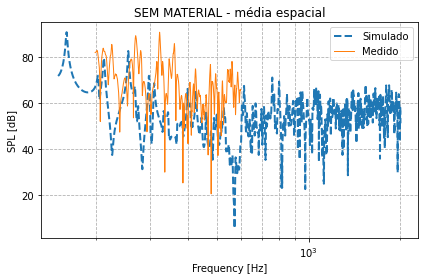

In [12]:
plt.title('SEM MATERIAL - média espacial')
pR_med = np.mean(obj.pR,axis=1) # R_semMat['R_semMatfreq'][2641:7921,n]
R_med = np.mean(R_semMat['pts_freq'][2641:7921],axis=1)
plt.semilogx(obj.freq, p2SPL(pR_med/max(abs(pR_med))), linestyle='--', label='Simulado', linewidth=2)
plt.semilogx(R_semMat['freqVector'][2641:7921,0], p2SPL(R_med/max(abs(R_med))), linestyle='-', label='Medido', linewidth=1)
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL [dB]')
# plt.ylim(40,160)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([100,125,160,200,250,315,400,500,630,1000,1250],[100,125,160,200,250,315,400,500,630,1000,1250]);
#plt.ylim(40,160)
plt.tight_layout()
plt.show()

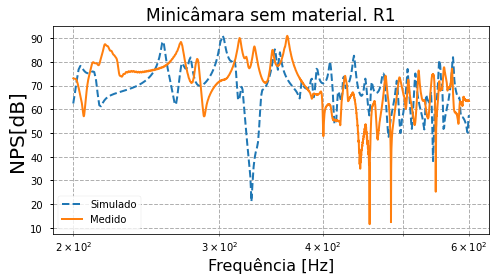

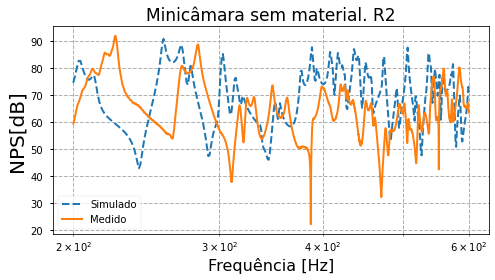

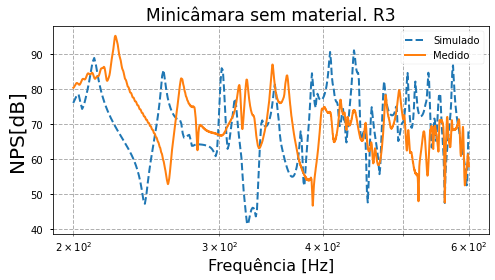

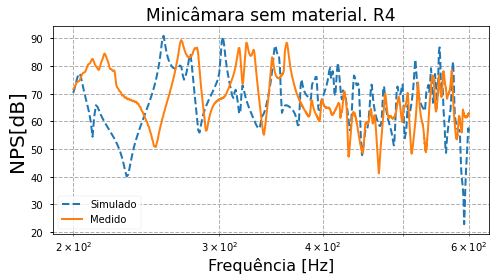

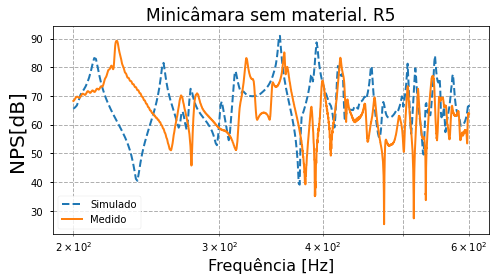

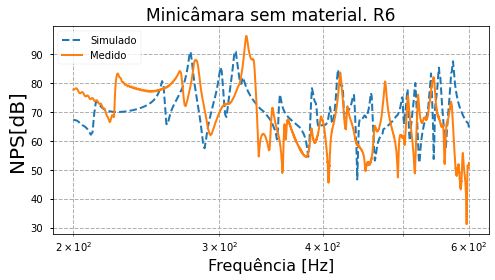

In [76]:
#Comparação NPS dos pontos medido e simulado 
# Q - cte.
for n in range(0,6):
    plt.figure(figsize=(7,4))
    plt.semilogx(AC.freq, p2SPL(obj.pR[:,n]/max(abs(obj.pR[:,n]))),label='Simulado', linestyle='--', linewidth=2)
    plt.semilogx(R_semMat['freqVector'][2641:7921,0], p2SPL(R_semMat['R_semMatfreq'][2641:7921,n]/max(abs(R_semMat['R_semMatfreq'][2641:7921,0]))), linestyle='-', label = 'Medido',linewidth=2)
    plt.grid(linestyle = '--', which='both')
    plt.legend(loc='best')
    plt.title(f'Minicâmara sem material. R{n+1}', fontsize=17)
    plt.xlabel('Frequência [Hz]', fontsize=16)
    plt.ylabel(r'NPS[dB]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
    plt.tight_layout()
# plt.ylim((0,0.2))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
    plt.show()  

### Comparação RIs dos pontos medido e simulado

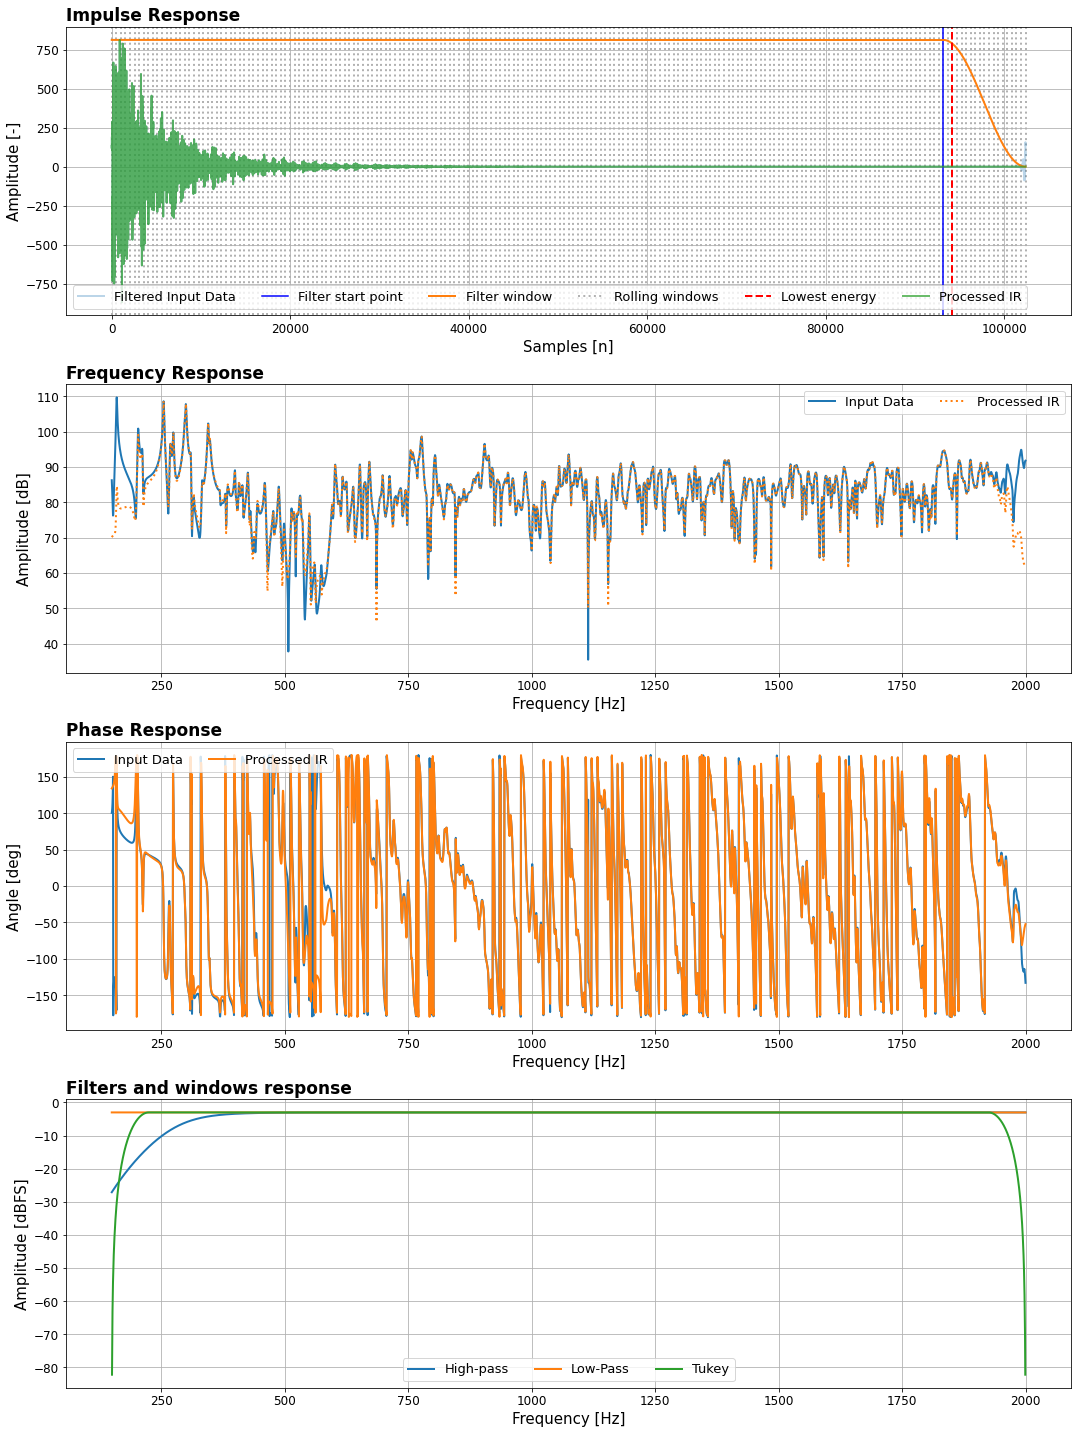

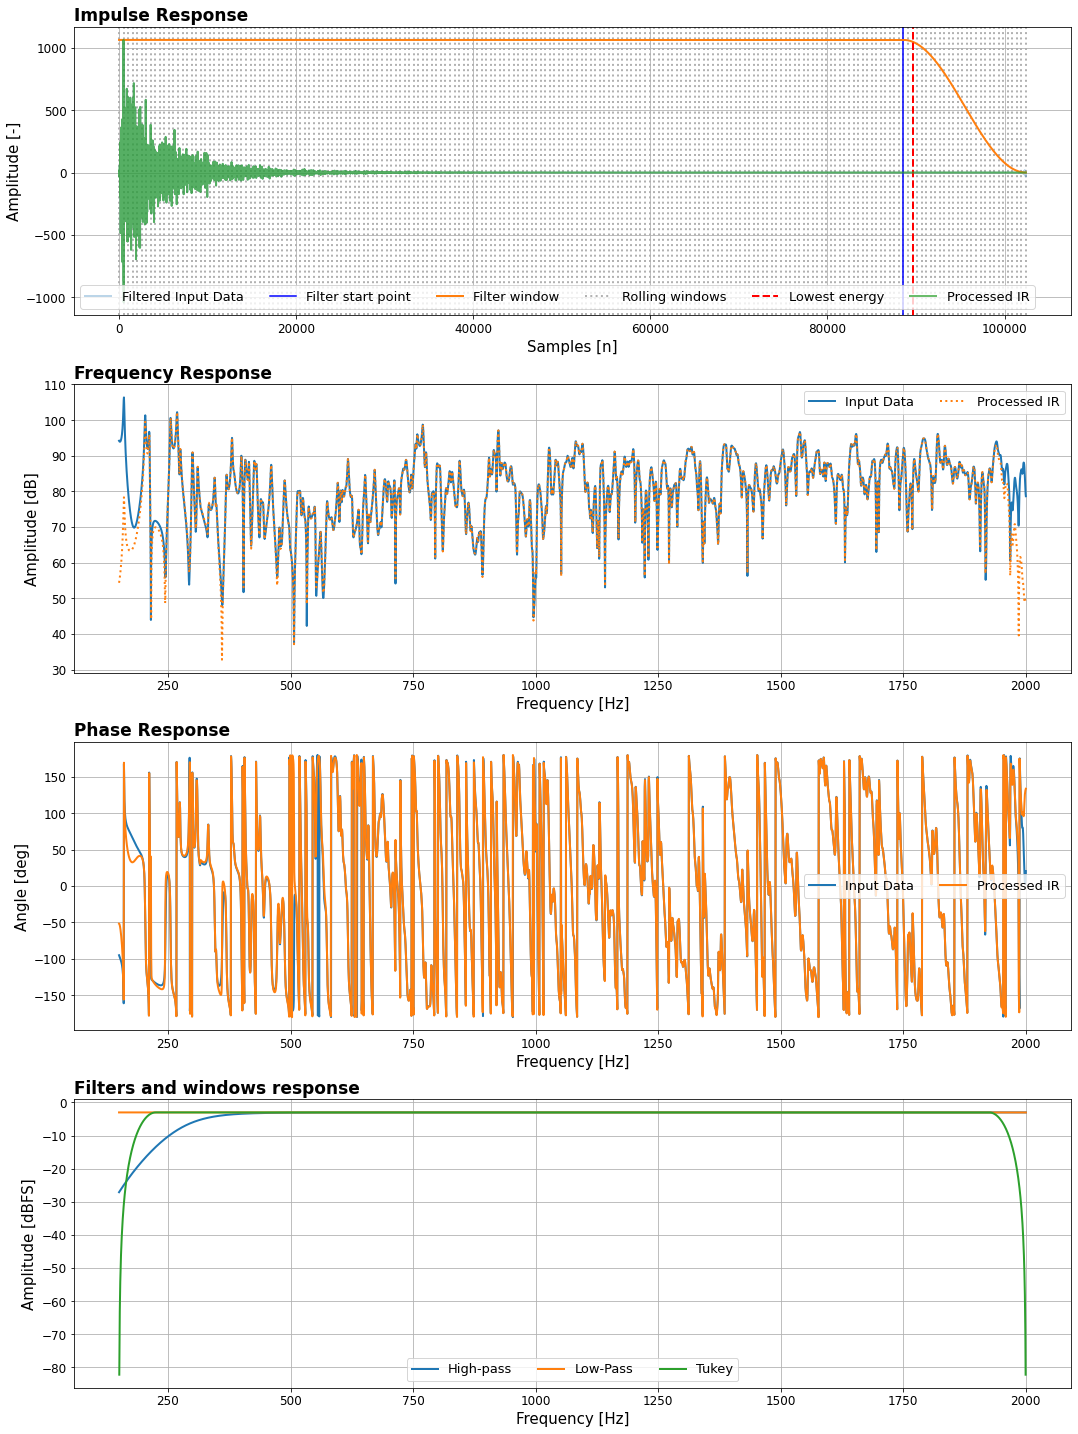

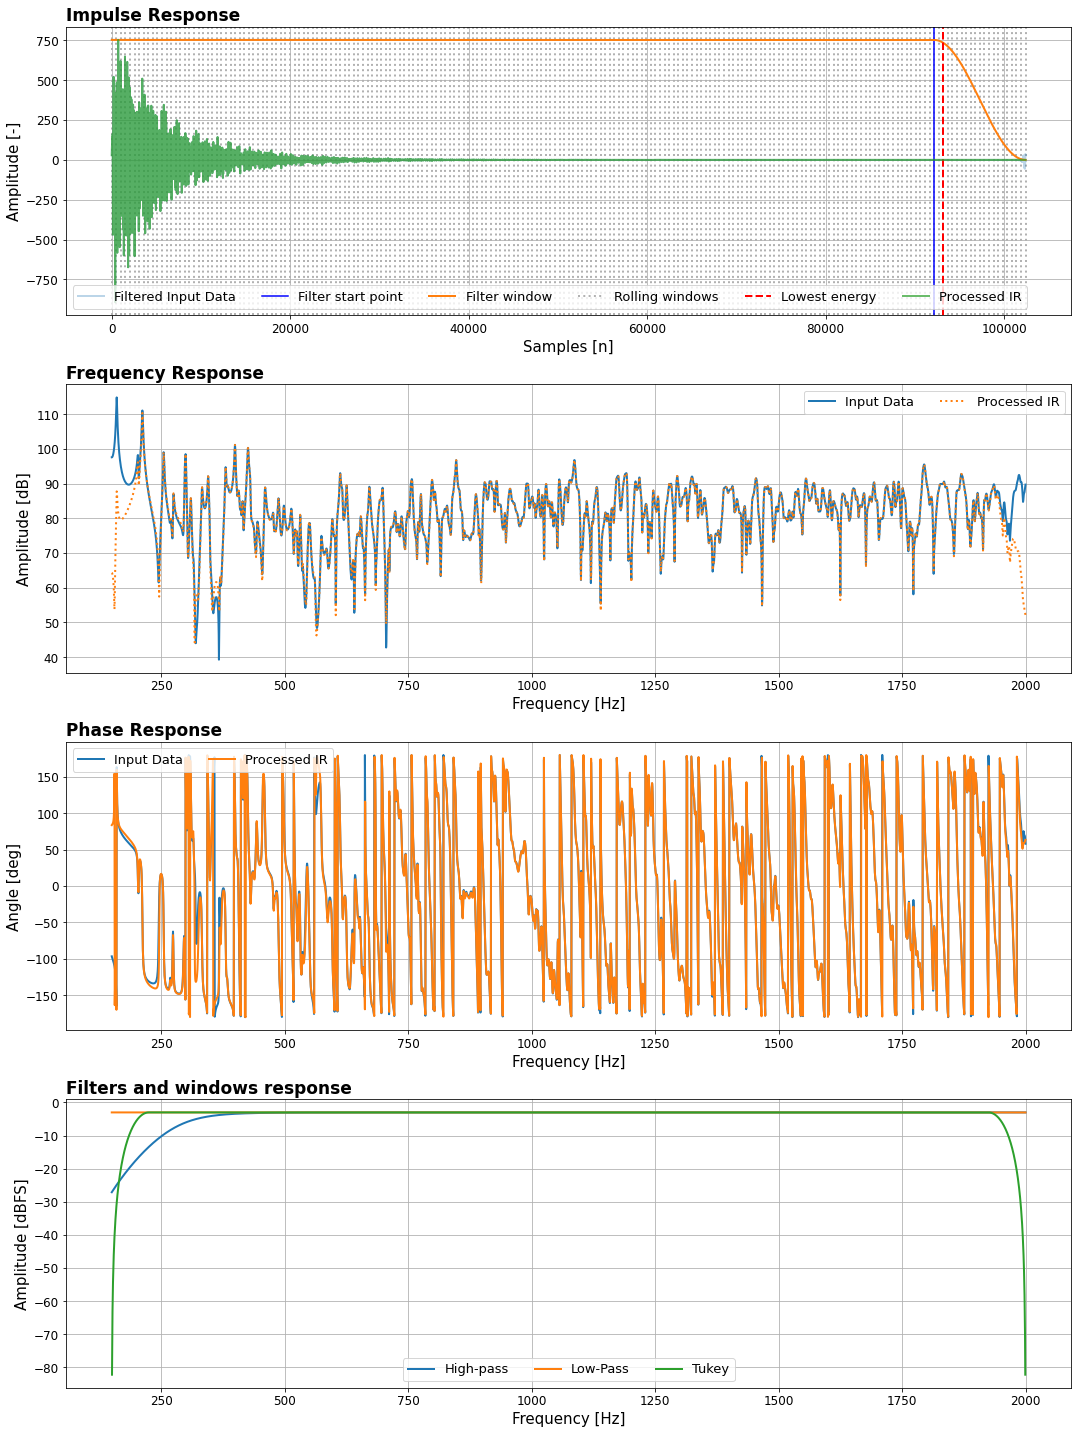

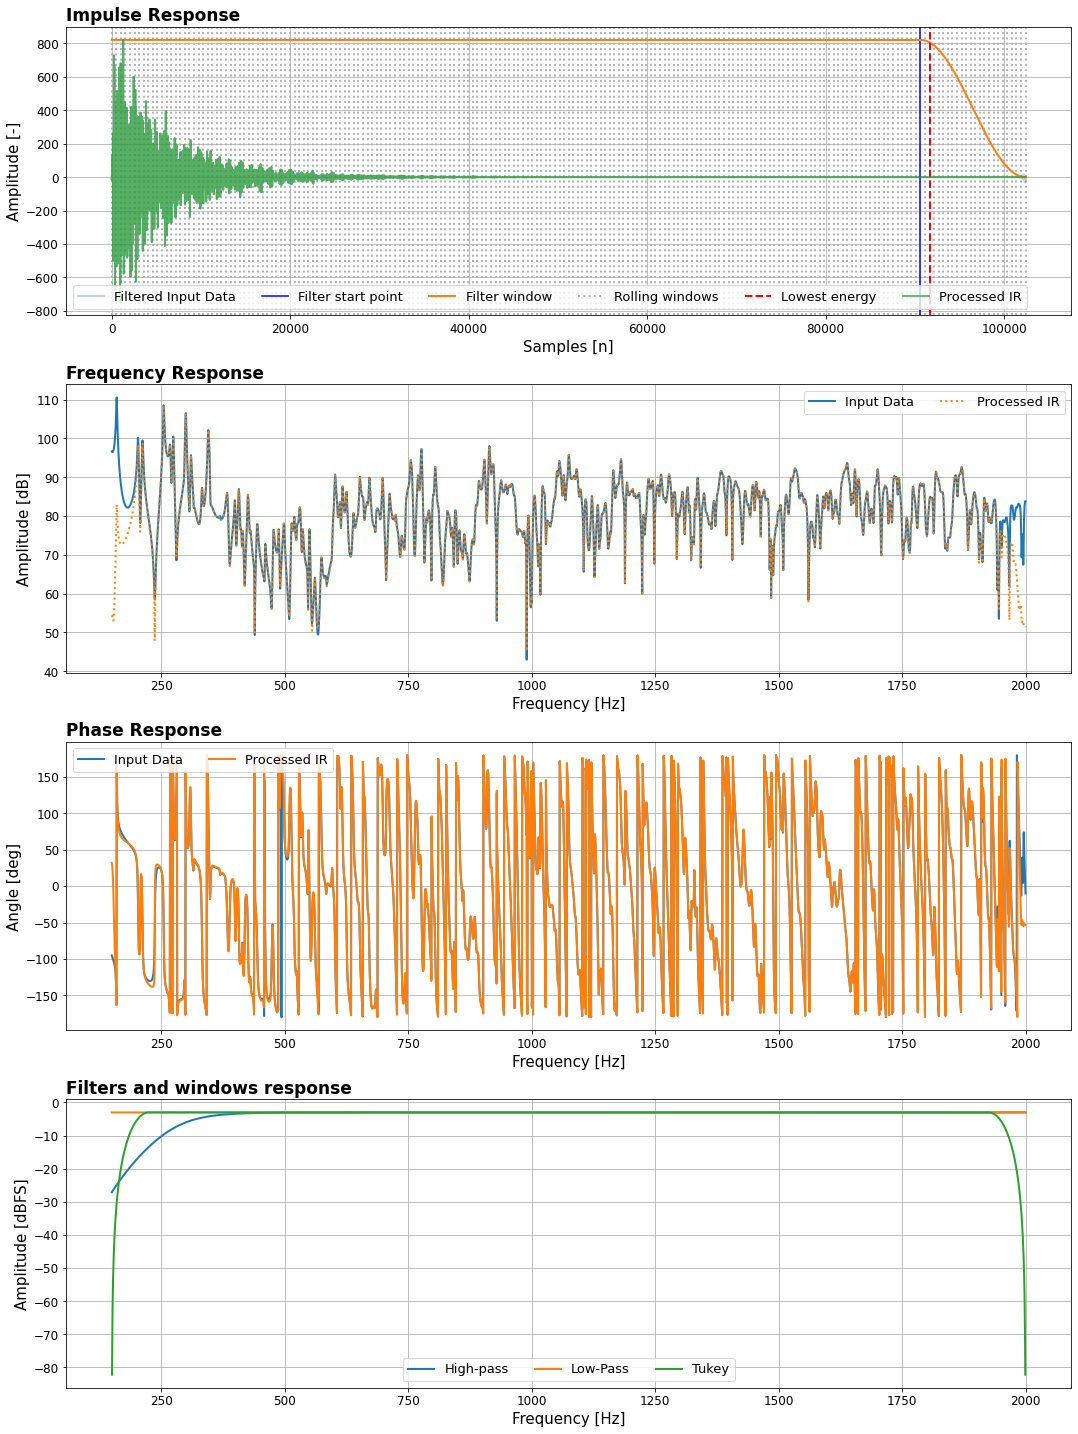

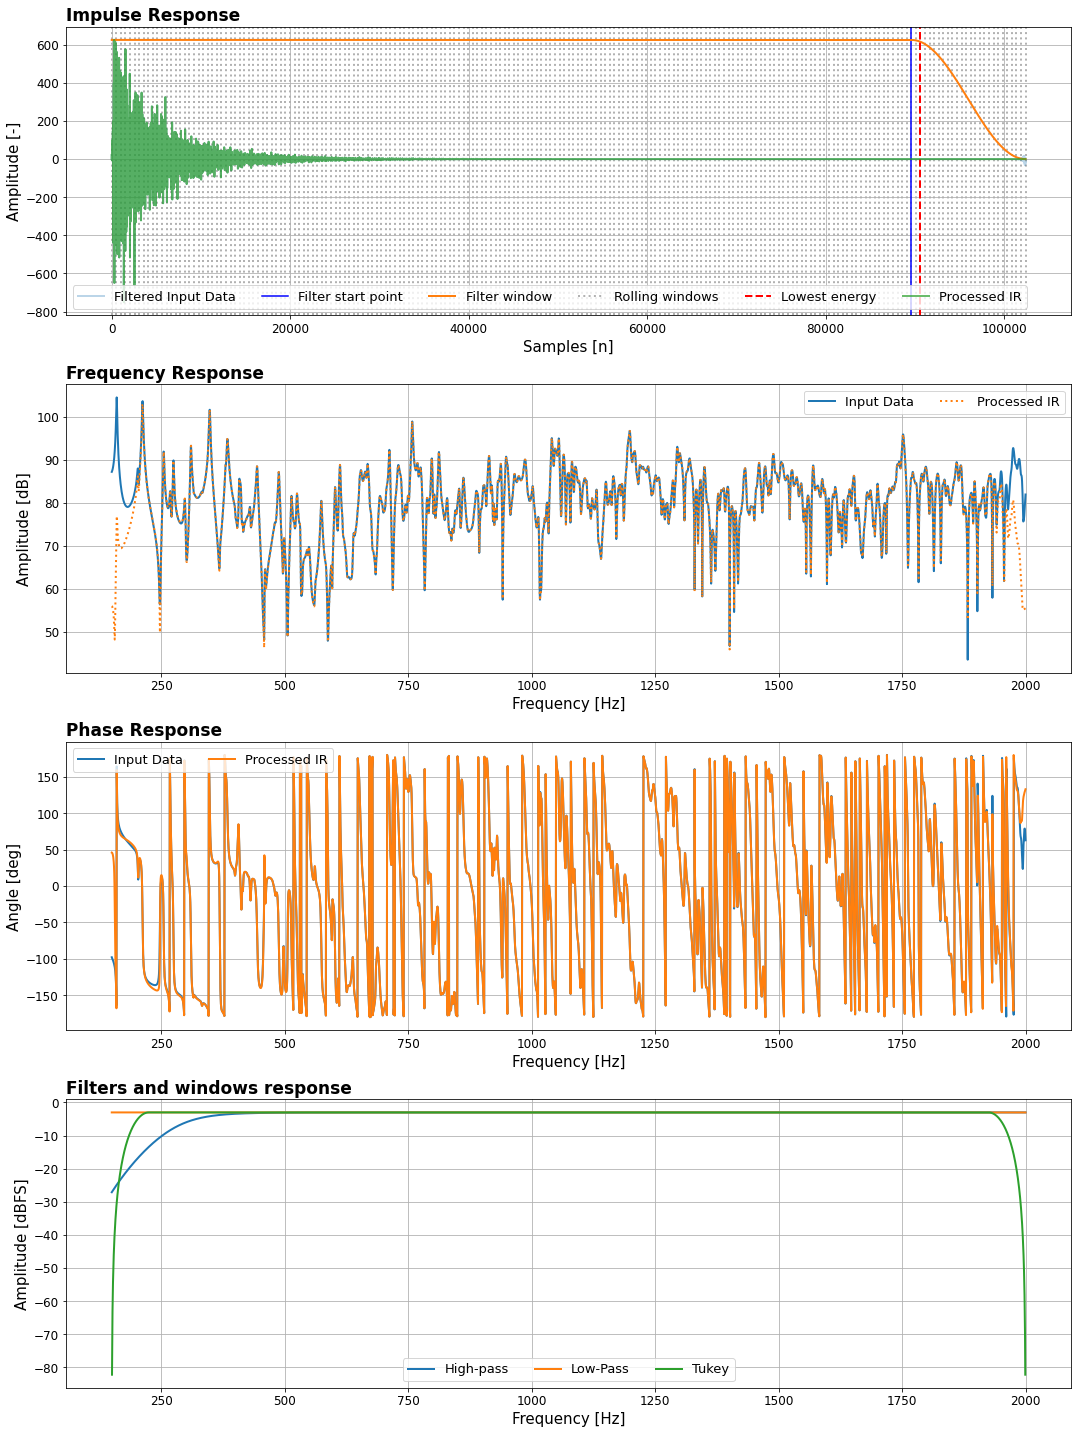

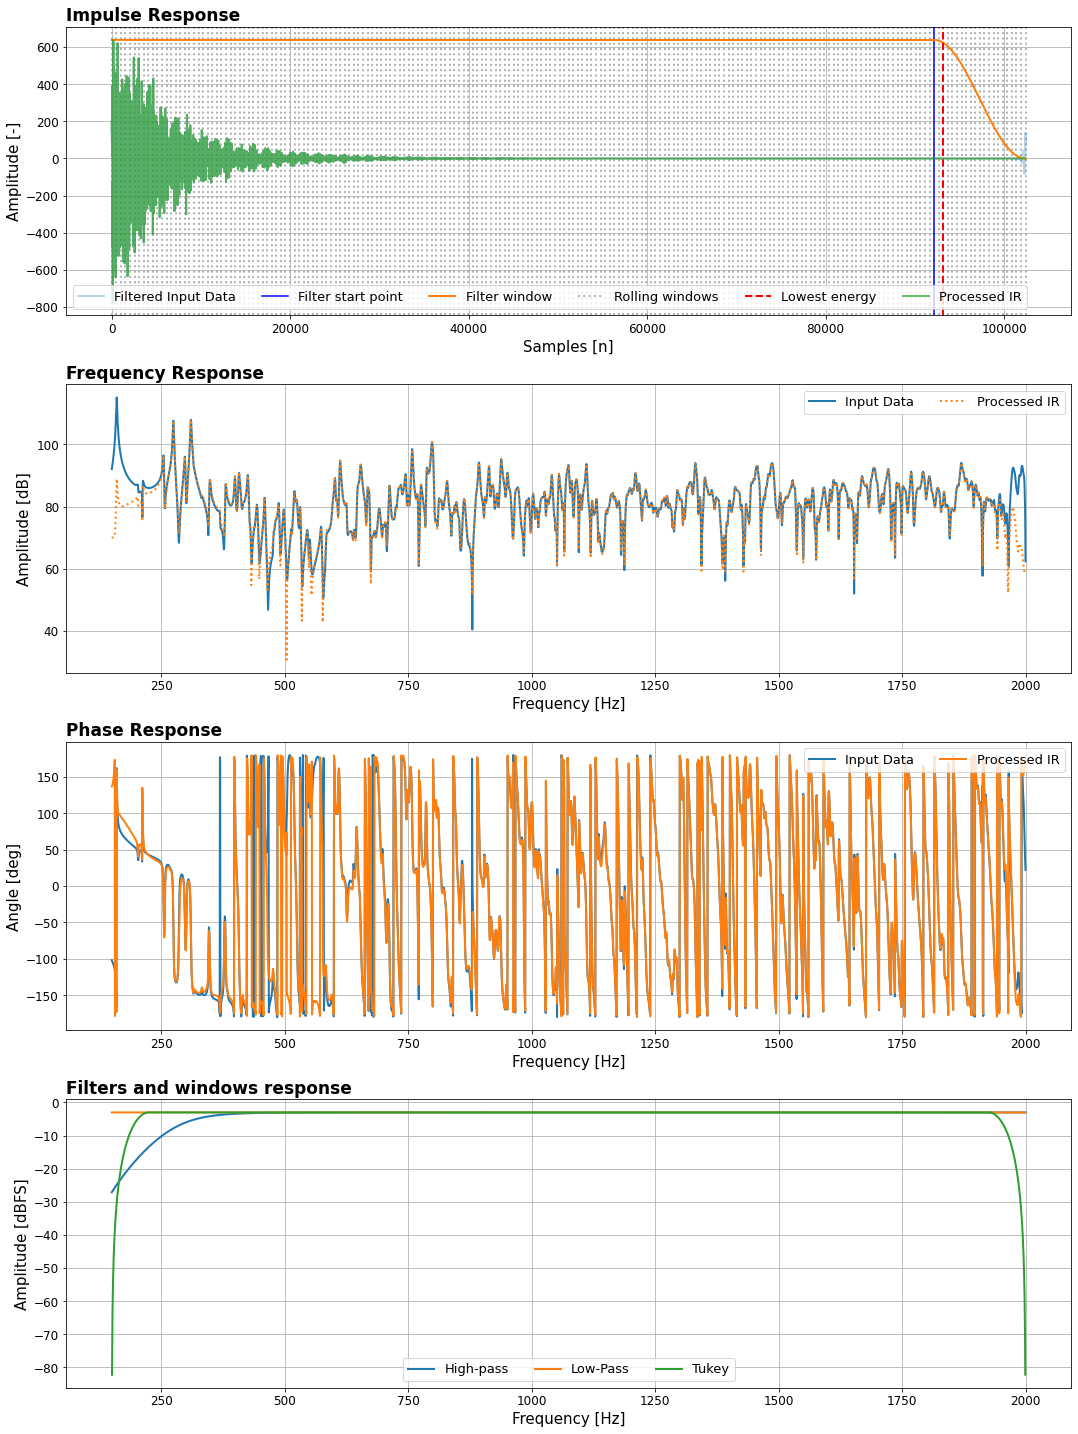

In [13]:
#%% Resposta Impulsiva
domain = fd.Domain(fmin, fmax,2,51200)
domain.alpha = 0.1
ir = np.zeros((len(RI_semMat['RIs_sz']),len(obj.pR[0,:])))
for n in range(0,len(obj.pR[0,:])):
    ir[:,n] = domain.compute_impulse_response(obj.pR[:,n], view=True, irr_filters=False)


In [14]:
# Salvar os dados p importar no MATLAB
from scipy.io import savemat
savemat('G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara_comMat\\espessura2_5cm\\fluido_eq\\RIs_simuladas.mat',{'RIs':ir,'freq':AC.freq})


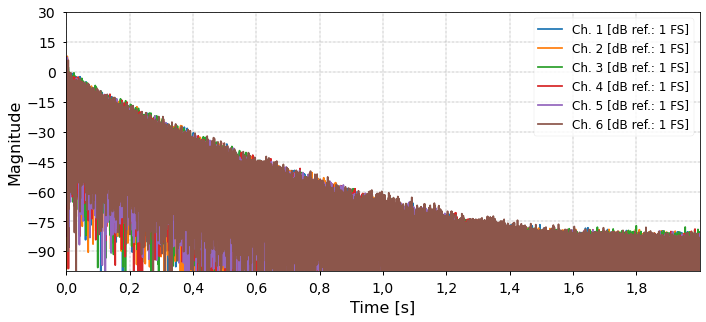

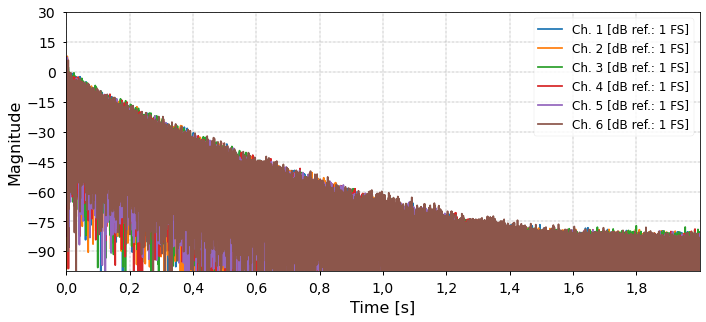

In [84]:

import pytta
txAmostragem = 51200 # [Hz]
# fftDegree = 19
# T = (2**fftDegree-1)/txAmostragem # [s]
# Cria vetor no tempo de um sinal aleatório
#meuRuido = np.random.randn(txAmostragem*T)
# SignalObj com sinal provido pelo usuário
RI_semMat = pytta.SignalObj(RI_semMat['RIs_sz'], 'time', txAmostragem) 
RI_semMat.plot_time_dB(yLim=[-100,30])

### Plote do campo de pressão

In [63]:
# Plote do campo de pressão
obj.pressure_field(frequencies = 300,renderer='browser',axis=['xy','yz'],saveFig=False,camera_angles=['diagonal_front'],extension='pdf')

G:\Meu Drive\TCC\Simulacao_computacional\codes\geo\mini-camarareverb.iges


100%|██████████| 203/203 [00:00<00:00, 2788.65it/s]



	Elapsed time to evaluate acoustic field: 0.09 minutes

